# 🔍 Détectez de faux billets

L'ONCFM est une insitution qui a pour objectif de mettre en place des méthodes pour détecter la contrefaçon de billets d'euros.
En tant que Data analyst, il m'a été demandé de travailler sur un jeu de données pour détecter et prédire des faux billets à l'aide de modèles de prédictions. 

# Sommaire

[Importations des librairies et du fichier](#Importations-des-librairies-et-du-fichier)

[Inspection et préparation des données](#Inspection-et-préparation-des-données)

[Prédiction des valeurs manquantes](#Prédiction-des-valeurs-manquantes)

- [1. Création du DF d'entrainement et du DF à prédire](#1.-Création-du-DF-d'entrainement-et-du-DF-à-prédire)
- [2. Matrice des corrélations](#2.-Matrice-des-corrélations)
- [3. Entrainement du modèle](#3.-Entrainement-du-modèle)
- [4. Application du modèle](#4.-Application-du-modèle)
- [5. Tests statistiques](#5.-Tests-statistiques)
    - [a. Colinéarités des variables](#a.-Colinéarités-des-variables)
    - [b. Homoscédasticité](#b.-Homoscédasticité)
    - [c. Normilité des résidus](#c.-Normilité-des-résidus)

[Prédiction des faux billets](#Prédiction-des-faux-billets)

- [1. Algorithme de K-means](#1.-Algorithme-de-K-means)
- [2. Régression logistique](#2.-Régression-logistique)
    - [a. Test du modèle sur échantillon](#a.-Test-du-modèle-sur-échantillon)
    - [b. Application du modèle sur l'ensemble complet](#b.-Application-du-modèle-sur-l'ensemble-complet)
    - [c. Ajustement des hyerparamètres](#c.-Ajustement-des-hyerparamètres)

[Conclusion](#Conclusion)

[Test de l'agorithme en direct](#Test-de-l'agorithme-en-direct)

- [1. Chargement du dataframe](#1.-Chargement-du-dataframe)
- [2. Régression logistique](#2.-Régression-logistique)
- [3. K-means](#3.-K-means)

# Importation des librairies et du fichier

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from scipy.stats import shapiro

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

billets = pd.read_csv('billets.csv', delimiter = ';')

# Inspection et préparation des données

In [102]:
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [103]:
billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [104]:
billets['is_genuine'] = billets['is_genuine'].astype(int)

# Prédiction des valeurs manquantes

## 1. Création du DF d'entrainement et du DF à prédire

In [105]:
# Création du DF à prédire
billets_to_predict = billets[billets.isna().any(axis=1)]

# Création du DF d'entrainement
billets_completed = billets.dropna()

In [106]:
billets_to_predict['is_genuine'].value_counts()

1    29
0     8
Name: is_genuine, dtype: int64

In [107]:
billets_completed.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000
mean,0.663705,171.959193,104.031333,103.921476,4.485967,3.153083,112.674757
std,0.472603,0.305457,0.299605,0.324181,0.663813,0.231466,0.873222
min,0.000000,171.040000,103.140000,102.910000,2.980000,2.270000,109.490000
25%,0.000000,171.750000,103.825000,103.710000,4.015000,2.990000,112.020000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.960000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.315000,113.340000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.320000


In [108]:
billets_completed[billets_completed['is_genuine'] == 0].describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,492.0,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,0.0,171.901402,104.188537,104.143272,5.215935,3.351504,111.632114
std,0.0,0.305473,0.224418,0.271683,0.553531,0.179343,0.615343
min,0.0,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,0.0,171.697500,104.040000,103.950000,4.840000,3.227500,111.200000
50%,0.0,171.910000,104.180000,104.160000,5.190000,3.350000,111.630000
75%,0.0,172.092500,104.330000,104.320000,5.592500,3.472500,112.030000
max,0.0,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


In [109]:
billets_completed[billets_completed['is_genuine'] == 1].describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,971.0,971.000000,971.000000,971.000000,971.000000,971.000000,971.000000
mean,1.0,171.988476,103.951679,103.809094,4.116097,3.052544,113.203059
std,0.0,0.301402,0.301518,0.288862,0.319124,0.185425,0.356123
min,1.0,171.040000,103.140000,102.910000,2.980000,2.270000,111.760000
25%,1.0,171.790000,103.745000,103.610000,3.905000,2.925000,112.960000
50%,1.0,171.990000,103.950000,103.810000,4.110000,3.050000,113.200000
75%,1.0,172.200000,104.140000,104.000000,4.340000,3.180000,113.460000
max,1.0,172.920000,104.860000,104.950000,5.040000,3.740000,114.320000


Cette première analyse donne un aperçu des différences qu'il peut y avoir entre les individus moyen (faux et vrai billet). La différence significative se situe principalement sur les variables margin_low et length. 

## 2. Matrice des corrélations

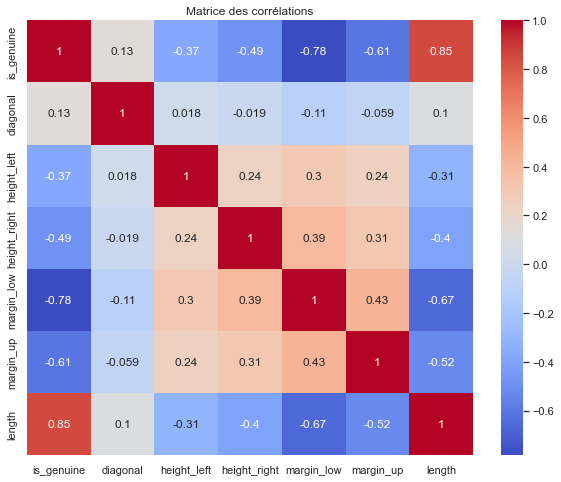

In [110]:
def create_correlation_matrix(data):
    # Calculer la matrice des corrélations
    correlation_matrix = billets_completed.corr()

    # Créer un heatmap de la matrice des corrélations
    sns.set(style="white")
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

    # Ajouter un titre
    plt.title("Matrice des corrélations")

    # Afficher le graphique
    plt.show()

# Utilisation de la fonction avec le DataFrame data
create_correlation_matrix(billets_completed)

## 3. Entrainement du modèle

In [111]:
# Entrainement du DF

X = billets_completed[['is_genuine','diagonal','height_left','height_right','margin_up','length']]
y = billets_completed['margin_low']

model = LinearRegression()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = round(r2_score(y_test, y_pred),4)
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),4)
mae = round(mean_absolute_error(y_test, y_pred),4)

print(f"R² : {r2}")
print(f"RMSE : {rmse}")
print(f"MAE : {mae}")


R² : 0.674
RMSE : 0.3707
MAE : 0.2895


- R² (Coefficient de détermination) : Il mesure la proportion de la variance de la variable dépendante ("margin_low") expliquée par le modèle. Le modèle explique environ 67.4% de la variance de "margin_low".


- RMSE (Erreur quadratique moyenne) : C'est la racine carrée de la moyenne des carrés des erreurs entre les valeurs observées et les valeurs prédites. Le RMSE indique en moyenne une erreur de prédiction d'environ 0.3707 unités pour "margin_low".


- MAE (Erreur absolue moyenne) : Il mesure la moyenne des valeurs absolues des erreurs entre les valeurs observées et les valeurs prédites. Le MAE indique en moyenne une erreur absolue de prédiction d'environ 0.2895 unités pour "margin_low".

## 4. Application du modèle

In [112]:
X = billets_completed[['is_genuine','diagonal','height_left','height_right','margin_up','length']]
y = billets_completed['margin_low']


model = LinearRegression()
model.fit(X_train, y_train)

# Prédiction des valeurs manquantes
X_test = billets_to_predict[['is_genuine','diagonal','height_left','height_right','margin_up','length']]
predicted_values = model.predict(X_test)

# Remplissage des valeurs prédites dans le DataFrame initial
billets_to_predict['margin_low'] = predicted_values

# Fusion des données avec valeurs prédites et sans valeurs manquantes
billets_new = pd.concat([billets_to_predict, billets_completed])

billets_new


/var/folders/gf/qtztgrtj40z_g_1rxg96hcqw0000gn/T/ipykernel_1622/1700944157.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billets_to_predict['margin_low'] = predicted_values


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,171.94,103.89,103.45,4.069384,3.25,112.79
99,1,171.93,104.07,104.18,4.103364,3.14,113.08
151,1,172.07,103.80,104.38,4.130311,3.02,112.93
197,1,171.45,103.66,103.80,3.993962,3.62,113.27
241,1,171.83,104.14,104.06,4.127607,3.02,112.36
...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.420000,3.09,111.28
1496,0,172.19,104.63,104.44,5.270000,3.37,110.97
1497,0,171.80,104.01,104.12,5.510000,3.36,111.95
1498,0,172.06,104.28,104.06,5.170000,3.46,112.25


## 5. Tests statistiques

### a. Colinéarités des variables

In [113]:
X = billets_new[['is_genuine','diagonal','height_left','height_right','margin_low','margin_up','length']] 
X = add_constant(X)

# Calcul des VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


       Variable            VIF
0         const  598184.370339
1    is_genuine       6.422020
2      diagonal       1.027481
3   height_left       1.181823
4  height_right       1.318171
5    margin_low       2.644137
6     margin_up       1.598746
7        length       3.593640


La colinéarité des variables est le phénomère statistique pour lequel deux variables sont fortement liés par une relation linéaire. 

Elle peut avoir plusieurs conséquences négatives lors de l'estimation du modèle de régression.

Le calcul du VIF (Variance Inflation Factor) permet d'identifier les colinéarités des variables. Un VIF inférieur à 10 indique une colinéarité modérée. 

### b. Homoscédasticité

In [114]:
# Calcul des résidus
residuals = y_test - y_pred

# Ajout des résidus au DataFrame initial
billets_new_bpt = billets_completed.copy()
billets_new_bpt['residuals'] = residuals

billets_new_bpt = billets_new_bpt.dropna()  
billets_new_bpt = billets_new_bpt.replace([np.inf, -np.inf], np.nan).dropna()

# Sélection des variables pour le test Breusch-Pagan
X_bp = billets_new_bpt[['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length', 'residuals']]

# Test de Breusch-Pagan
lm, p_value, fvalue, f_pvalue = het_breuschpagan(residuals, X_bp)
print(f"P-value du test de Breusch-Pagan : {p_value}")


P-value du test de Breusch-Pagan : 6.654972416299406e-16


- P-value < 0.05 : On rejette l'hypothèse nulle d'homoscédasticité.

- P-value ≥ 0.05 : On ne rejette pas l'hypothèse nulle, ce qui suggère que l'homoscédasticité peut être présente.

Dans ce cas, la p-value étant très proche de zéro, les preuves statistiques sont suffisantes pour rejeter l'hypothèse nulle d'homoscédasticité. Cela indique que l'hétéroscédasticité (une variation inégale de la variance des résidus le long de la plage des valeurs prédites) est présente dans le modèle de régression.

Il y a donc un risque que la prédiction ne soit pas complètement fiable. 

### c. Normilité des résidus

In [115]:
# Récupérer les résidus
residuals = billets_new_bpt['residuals']

# Test de normalité de Shapiro-Wilk
statistic, p_value = shapiro(residuals)

print(f"Statistique de test Shapiro-Wilk : {statistic}")
print(f"P-value du test Shapiro-Wilk : {p_value}")

# Interprétation du test de normalité
if p_value > 0.05:
    print("Les résidus suivent une distribution normale (nous ne pouvons pas rejeter l'hypothèse nulle).")
else:
    print("Les résidus ne suivent pas une distribution normale (nous rejetons l'hypothèse nulle).")


Statistique de test Shapiro-Wilk : 0.9906145930290222
P-value du test Shapiro-Wilk : 0.057557232677936554
Les résidus suivent une distribution normale (nous ne pouvons pas rejeter l'hypothèse nulle).


Le résultat du test est très rassurant car la non-normalités des résidus aurait eu les impacts suivant : 

- Validité des tests statistiques : Si les résidus ne suivent pas une distribution normale, les tests statistiques basés sur cette supposition peuvent produire des résultats biaisés.


- Validité des intervalles de prédiction : La normalité des résidus est également importante pour les intervalles de prédiction. Les intervalles de prédiction supposent également une distribution normale des résidus.


- Fiabilité des prédictions : La non-normalité des résidus peut affecter la fiabilité des prédictions. Les modèles de régression basés sur des résidus non normaux peuvent produire des intervalles de prédiction qui ne capturent pas correctement l'incertitude associée aux prédictions.

# Prédiction des faux billets

## 1. Algorithme de K-means

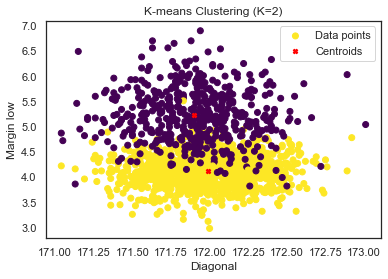

In [116]:
# Sélection des variables pertinentes pour le clustering
X_cluster = billets_new[['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low' ,'margin_up', 'length']]

# Application du K-means avec K=2
kmeans = KMeans(n_clusters=2, random_state=42)
billets_new['cluster_kmeans'] = kmeans.fit_predict(X_cluster)

# Obtenir les centroids
centroids = kmeans.cluster_centers_

# Visualisation des clusters en fonction de deux variables
plt.scatter(billets_new['diagonal'], billets_new['margin_low'], c=billets_new['cluster_kmeans'], cmap='viridis', label='Data points')
plt.scatter(centroids[:, 1], centroids[:, 4], c='red', marker='X', s=20, label='Centroids')
plt.title('K-means Clustering (K=2)')
plt.xlabel('Diagonal')
plt.ylabel('Margin low')
plt.legend()
plt.show()

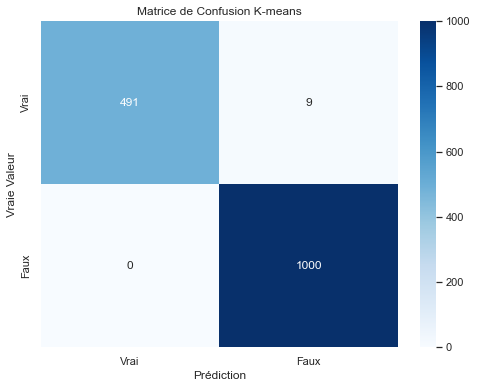

Accuracy K-means : 0.994


In [117]:
# Création du DataFrame avec les étiquettes réelles et prédites
df_result = pd.DataFrame({'Vraie Valeur': billets_new['is_genuine'], 'Cluster Assigné': billets_new['cluster_kmeans']})

# Création de la matrice de confusion
conf_matrix = confusion_matrix(df_result['Vraie Valeur'], df_result['Cluster Assigné'])

# Calcul de l'accuracy
acc = accuracy_score(df_result['Vraie Valeur'], df_result['Cluster Assigné'])

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Vrai', 'Faux'], yticklabels=['Vrai', 'Faux'])
plt.xlabel('Prédiction')
plt.ylabel('Vraie Valeur')
plt.title('Matrice de Confusion K-means')
plt.show()

# Affichage de l'accuracy
print(f"Accuracy K-means : {acc}")

## 2. Régression logistique

###  a. Test du modèle sur échantillon

In [118]:
# Initialisation et entraînement du modèle

X = billets_new.drop(['is_genuine', 'cluster_kmeans'], axis=1) 
y = billets_new['is_genuine']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Prédictions sur l'ensemble test
y_pred = logistic_model.predict(X_test)

# Calcul de l'accuracy et affichage
acc_logistic = round(accuracy_score(y_test, y_pred),4)
print(f'Accuracy ensemble test : {acc_logistic}')


Accuracy ensemble test : 0.9967


### b. Application du modèle sur l'ensemble complet

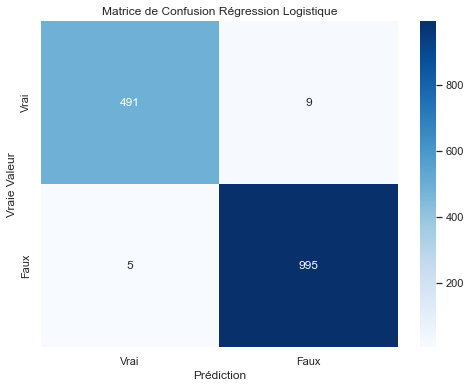

Accuracy Régression Logistique: 0.9907


In [119]:
#Application du modèle sur l'ensemble complet
logistic_model.fit(X, y)
billets_new['cluster_RL'] = logistic_model.predict(X)

# Calcul de l'accuracy et affichage de la matrice de confusion
acc_logistic_full = round(accuracy_score(y, billets_new['cluster_RL']),4)
conf_matrix_logistic_full = confusion_matrix(y, billets_new['cluster_RL'])


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logistic_full, annot=True, fmt='d', cmap='Blues', xticklabels=['Vrai', 'Faux'], yticklabels=['Vrai', 'Faux'])
plt.xlabel('Prédiction')
plt.ylabel('Vraie Valeur')
plt.title('Matrice de Confusion Régression Logistique')
plt.show()

print(f'Accuracy Régression Logistique: {acc_logistic_full}')

### c. Ajustement des hyerparamètres

/Users/nassim/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/nassim/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


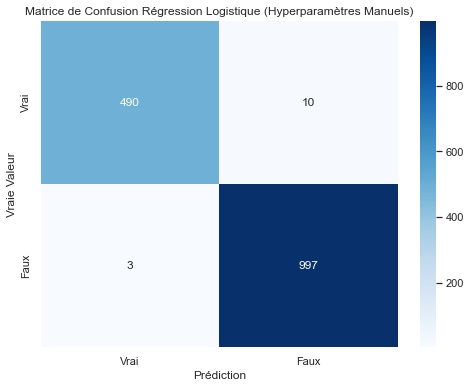

Accuracy Régression Logistique (Hyperparamètres Manuels): 0.9913


In [120]:
penalty = 'l2'  # Choix entre : 'l1', 'l2'
C_value = 1.0  # Valeur de l'inverse de la force de régularisation
solver = 'newton-cg'  # Choix entre : 'liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'
max_iter = 100  # Nombre maximal d'itérations

# Initialisation du modèle de régression logistique avec les hyperparamètres choisis
logistic_model = LogisticRegression(penalty=penalty, C=C_value, solver=solver, max_iter=max_iter)

# Adaptation du modèle aux données
logistic_model.fit(X, y)

# Utilisation du modèle pour faire des prédictions
billets_new['cluster_RL'] = logistic_model.predict(X)

# Calcul de l'accuracy et affichage de la matrice de confusion
acc_logistic_manual = round(accuracy_score(y, billets_new['cluster_RL']), 4)
conf_matrix_logistic_manual = confusion_matrix(y, billets_new['cluster_RL'])

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logistic_manual, annot=True, fmt='d', cmap='Blues', xticklabels=['Vrai', 'Faux'], yticklabels=['Vrai', 'Faux'])
plt.xlabel('Prédiction')
plt.ylabel('Vraie Valeur')
plt.title('Matrice de Confusion Régression Logistique (Hyperparamètres Manuels)')
plt.show()

print(f'Accuracy Régression Logistique (Hyperparamètres Manuels): {acc_logistic_manual}')

# Conclusion

Les 2 algorithmes affichent des résultats plus que satisfaisant avec des accuracy atteignant les 99%. 
Il semble néanmoins que l'algorithme de K-means soit plus performant dans notre cas (99,4% vs 99,1%). 

# Test des algorithmes en direct

## 1. Chargement du dataframe

In [121]:
billets_prod = pd.read_csv('billets_test.csv', delimiter = ',')
billets_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


## 2. Régression logistique

In [122]:
billets_prod.drop('id', axis = 1, inplace = True)
test = logistic_model.predict(billets_prod)
billets_prod['cluster_RL'] = test
billets_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_RL
0,172.09,103.95,103.73,4.39,3.09,113.19,1
1,171.52,104.17,104.03,5.27,3.16,111.82,0
2,171.78,103.80,103.75,3.81,3.24,113.39,1
3,172.02,104.08,103.99,5.57,3.30,111.10,0
4,171.79,104.34,104.37,5.00,3.07,111.87,0


## 3. K-means

In [123]:
X_cluster = billets_prod[['diagonal', 'height_left', 'height_right', 'margin_low' ,'margin_up', 'length']]

# Application du K-means avec K=2
kmeans = KMeans(n_clusters=2, random_state=42)
billets_prod['cluster_kmeans'] = kmeans.fit_predict(X_cluster)

In [124]:
billets_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_RL,cluster_kmeans
0,172.09,103.95,103.73,4.39,3.09,113.19,1,1
1,171.52,104.17,104.03,5.27,3.16,111.82,0,0
2,171.78,103.80,103.75,3.81,3.24,113.39,1,1
3,172.02,104.08,103.99,5.57,3.30,111.10,0,0
4,171.79,104.34,104.37,5.00,3.07,111.87,0,0
